In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sbcbinaryformat import Streamer, Writer
import scipy.signal as sg
from pathlib import Path
import json
import math

ana_path = "../LAr10Ana/"
sys.path.insert(0, ana_path)

from GetEvent import GetEvent, GetRun

%matplotlib inline

In [2]:
recon_path = Path("/exp/e961/data/SBC-25-recon/dev-output/")
data_path = Path("/exp/e961/data/SBC-25-daqdata/")

In [3]:
def gen_run_numbers(run_ranges):
    # input is a tuple or a list of tuples, which contains (date, start_run, end_run)
    if isinstance(run_ranges, tuple):
        run_ranges = [run_ranges]

    ret = [
        f"{date}_{run}"
        for date, start, end in run_ranges
        for run in range(start, end + 1)
    ]

    return ret
    

In [4]:
def get_info(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/"):
    runs = set(runs)
    total_evs = 0
    total_clock_time = 0
    total_livetime = 0

    for run in runs:
        try:
            data = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
        except FileNotFoundError:
            print(f"Run {run} file not available. Skipping...")
            continue
        
        livetime = data["PT2121_livetime"]
        total_evs += len(livetime)
        total_livetime += np.sum(livetime)

        clock_time = Streamer(os.path.join(recon_path, run, "event.sbc")).to_dict()
        total_clock_time += np.sum(clock_time["ev_livetime"])/1000

    return total_clock_time/3600, total_evs, total_livetime/3600

In [11]:
def get_livetime_by_pset(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/"):
    pset_livetimes = {}

    for run in runs:
        try:
            data = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
        except FileNotFoundError:
            print(f"Run {run} file not available. Skipping...")
            continue
        
        pt2121 = data["PT2121_pressure"]
        livetime = data["PT2121_livetime"]

        for ev in range(len(pt2121)):
            real_p = pt2121[ev]
            event_info = GetEvent(os.path.join(data_path, run + ".tar"), ev, "event_info")["event_info"]
            pset_lo = event_info["pset_lo"][0]
            pset_hi = event_info["pset_hi"][0]

            # Skip bad events
            if math.isnan(real_p) or abs(pset_hi - pset_lo) > 0.1 or abs(pset_lo - real_p) > 0.5:
                continue

            # Round pset 0.25
            pset_bin = round(pset_lo * 4) / 4
            
            if pset_bin not in pset_livetimes:
                pset_livetimes[pset_bin] = []
            pset_livetimes[pset_bin].append(livetime[ev])
            print(f"run {run} ev {ev}:\tpset: {pset_bin},\tlivetime: {livetime[ev]}s")

    # Calculate average and error for each bin
    print("\n")
    results = {}
    for pset, lts in sorted(pset_livetimes.items()):
        lts = np.array(lts)
        results[pset] = {
            "n_events":  len(lts),
            "total":     np.sum(lts),
            "mean":      np.mean(lts),
            "std":       np.std(lts),
            "error":     np.std(lts) / np.sqrt(len(lts)),  # standard error
        }
        print(f"pset: {pset:.1f} bar | n={len(lts):4d} | total={np.sum(lts):8.2f}s | mean={np.mean(lts):.3f}s ± {np.std(lts)/np.sqrt(len(lts)):.3f}s")

    return results

In [22]:
def get_livetime_by_pset_rounded(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/", min_livetime=60):
    pset_livetimes = {}

    for run in runs:
        try:
            exposure = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
        except FileNotFoundError:
            # print(f"Run {run} file not available. Skipping...")
            continue
        
        pt2121 = exposure["PT2121_pressure"]
        livetime = exposure["PT2121_livetime"]

        for ev in range(len(pt2121)):
            real_p = pt2121[ev]

            # Round pset 0.25
            if math.isnan(real_p):
                continue
            elif livetime[ev] < 1:
                continue
            elif real_p <=2.5:
                pset_bin = round(real_p * 4) / 4
            else:
                pset_bin = round(real_p * 2) / 2

            
            if pset_bin not in pset_livetimes:
                pset_livetimes[pset_bin] = []
            pset_livetimes[pset_bin].append(livetime[ev])
            # print(f"run {run} ev {ev}:\tpset: {pset_bin},\tlivetime: {livetime[ev]}s")

    # Calculate average and error for each bin
    results = {}
    for pset, lts in sorted(pset_livetimes.items()):
        lts = np.array(lts)
        if np.sum(lts) < min_livetime:
            continue
        results[pset] = {
            "n_events":  len(lts),
            "total":     np.sum(lts),
            "mean":      np.mean(lts),
            "std":       np.std(lts),
            "error":     np.std(lts) / np.sqrt(len(lts)),  # standard error
        }
        print(f"pset: {pset:.2f} bar | n={len(lts):4d} | total={np.sum(lts):8.2f}s | mean={np.mean(lts):.3f}s ± {np.std(lts)/np.sqrt(len(lts)):.3f}s")

    print("\n")
    return results

In [8]:
def plot_livetime_by_pset(results, title=None):
    psets  = sorted(results.keys())
    means  = [results[p]["mean"]    for p in psets]
    stds   = [results[p]["std"]     for p in psets]
    errors = [results[p]["error"]   for p in psets]
    totals = [results[p]["total"]   for p in psets]

    fig = plt.figure()

    plt.errorbar(psets, means, yerr=stds, fmt="o", capsize=4)
    plt.ylabel("Livetime (s)")
    plt.xlabel("Pressure (bar)")
    plt.yscale("log")
    plt.ylim(0.5,)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [41]:
run = "20260206_12"
data = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
pt2121 = data["PT2121_pressure"]
livetime = data["PT2121_livetime"]

for ev in range(len(pt2121)):
    real_p = pt2121[ev]
    
    
    event_info = GetEvent(os.path.join(data_path, run+".tar"), ev, "event_info")["event_info"]
    pset_lo, pset_hi = event_info["pset_lo"][0], event_info["pset_hi"][0]

    if math.isnan(real_p) or abs(pset_hi - pset_lo)>0.1 or abs(pset_lo - real_p)>0.5:
        print("Bad event!", end="\t")
        # continue
    else:
        print("", end="\t\t")
    
    print(f"ev: {ev}", end=",\t")
    print(f"real_p: {real_p:.3f}", end=",\t")
    print(f"pset: {pset_lo:.1f}", end=",\t")
    print(f"livetime: {livetime[ev]:5.2f}s")

Bad event!	ev: 0,	real_p: nan,	pset: 2.0,	livetime:  0.00s
Bad event!	ev: 1,	real_p: 4.728,	pset: 3.0,	livetime:  1.26s
		ev: 2,	real_p: 4.020,	pset: 4.0,	livetime:  7.93s
		ev: 3,	real_p: 5.017,	pset: 5.0,	livetime:  7.40s
		ev: 4,	real_p: 2.425,	pset: 2.0,	livetime:  0.00s
		ev: 5,	real_p: 3.460,	pset: 3.0,	livetime:  0.02s
		ev: 6,	real_p: 4.018,	pset: 4.0,	livetime:  1.86s
		ev: 7,	real_p: 5.017,	pset: 5.0,	livetime:  1.98s
Bad event!	ev: 8,	real_p: 3.018,	pset: 2.0,	livetime:  0.06s
Bad event!	ev: 9,	real_p: 5.098,	pset: 3.0,	livetime:  1.64s
		ev: 10,	real_p: 4.019,	pset: 4.0,	livetime:  2.10s
		ev: 11,	real_p: 5.018,	pset: 5.0,	livetime:  7.50s
Bad event!	ev: 12,	real_p: nan,	pset: 2.0,	livetime:  0.00s
		ev: 13,	real_p: 3.312,	pset: 3.0,	livetime:  0.06s
		ev: 14,	real_p: 4.466,	pset: 4.0,	livetime:  0.03s
		ev: 15,	real_p: 5.013,	pset: 5.0,	livetime:  0.83s
Bad event!	ev: 16,	real_p: 2.822,	pset: 2.0,	livetime:  0.04s
Bad event!	ev: 17,	real_p: 3.894,	pset: 3.0,	livetime:  0.1

In [57]:
bg_scint_data = ["20260217_7", "20260217_8", "20260217_9"]
livetimes = get_livetime_by_pset(bg_scint_data)
plot_livetime_by_pset(livetimes)

run 20260217_7 ev 1:	pset: 2.0,	livetime: 7.94s
run 20260217_7 ev 2:	pset: 2.5,	livetime: 5.82s
run 20260217_7 ev 3:	pset: 3.0,	livetime: 3.76s
run 20260217_7 ev 4:	pset: 4.0,	livetime: 9.35s
run 20260217_7 ev 5:	pset: 5.0,	livetime: 13.92s
run 20260217_7 ev 6:	pset: 1.5,	livetime: 5.7s
run 20260217_7 ev 8:	pset: 2.5,	livetime: 38.19s
run 20260217_7 ev 9:	pset: 3.0,	livetime: 17.53s
run 20260217_7 ev 10:	pset: 4.0,	livetime: 104.69s
run 20260217_7 ev 11:	pset: 5.0,	livetime: 26.07s
run 20260217_7 ev 12:	pset: 1.5,	livetime: 29.61s
run 20260217_7 ev 13:	pset: 2.0,	livetime: 15.52s
run 20260217_7 ev 14:	pset: 2.5,	livetime: 30.28s
run 20260217_7 ev 15:	pset: 3.0,	livetime: 54.49s
run 20260217_7 ev 16:	pset: 4.0,	livetime: 12.02s
run 20260217_7 ev 17:	pset: 5.0,	livetime: 49.29s
run 20260217_7 ev 19:	pset: 2.0,	livetime: 21.09s
run 20260217_7 ev 20:	pset: 2.5,	livetime: 31.45s
run 20260217_7 ev 21:	pset: 3.0,	livetime: 0.86s
run 20260217_7 ev 23:	pset: 5.0,	livetime: 12.6s
run 20260217_7 

run 20260206_9 ev 0:	pset: 2.0,	livetime: 3.64s
run 20260206_9 ev 1:	pset: 3.0,	livetime: 2.74s
run 20260206_10 ev 0:	pset: 1.5,	livetime: 0.09s
run 20260206_10 ev 1:	pset: 1.75,	livetime: 0.3s
run 20260206_10 ev 2:	pset: 2.0,	livetime: 0.31s
run 20260206_10 ev 3:	pset: 3.0,	livetime: 5.1s
run 20260206_10 ev 4:	pset: 4.0,	livetime: 2.89s
run 20260206_10 ev 5:	pset: 5.0,	livetime: 13.61s
run 20260206_11 ev 2:	pset: 2.0,	livetime: 1.58s
run 20260206_11 ev 3:	pset: 3.0,	livetime: 0.26s
run 20260206_11 ev 4:	pset: 4.0,	livetime: 5.47s
run 20260206_11 ev 5:	pset: 5.0,	livetime: 14.63s
run 20260206_12 ev 2:	pset: 4.0,	livetime: 7.93s
run 20260206_12 ev 3:	pset: 5.0,	livetime: 7.4s
run 20260206_12 ev 4:	pset: 2.0,	livetime: 0.0s
run 20260206_12 ev 5:	pset: 3.0,	livetime: 0.02s
run 20260206_12 ev 6:	pset: 4.0,	livetime: 1.86s
run 20260206_12 ev 7:	pset: 5.0,	livetime: 1.98s
run 20260206_12 ev 10:	pset: 4.0,	livetime: 2.1s
run 20260206_12 ev 11:	pset: 5.0,	livetime: 7.5s
run 20260206_12 ev 13:	

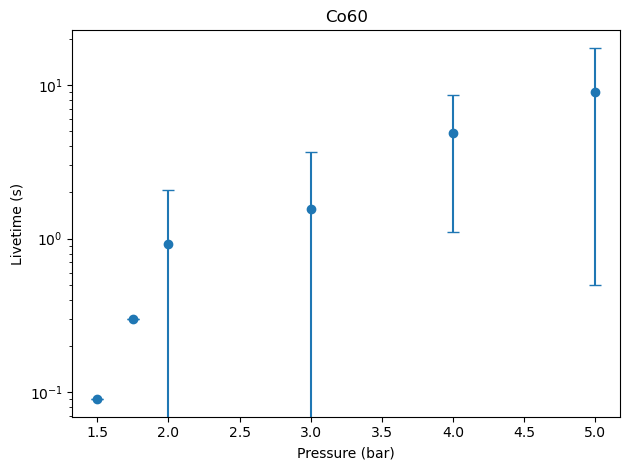

In [84]:
co_scint_data = ["20260206_8", "20260206_9", "20260206_10", "20260206_11", "20260206_12"]
livetimes = get_livetime_by_pset(co_scint_data)
plot_livetime_by_pset(livetimes, title="Co60")

run 20260202_16 ev 3:	pset: 3.0,	livetime: 1.07s
run 20260202_16 ev 4:	pset: 4.0,	livetime: 0.63s
run 20260202_16 ev 5:	pset: 5.0,	livetime: 7.88s
run 20260202_16 ev 10:	pset: 4.0,	livetime: 3.06s
run 20260202_16 ev 11:	pset: 5.0,	livetime: 6.21s
run 20260202_16 ev 14:	pset: 2.5,	livetime: 0.2s
run 20260202_16 ev 15:	pset: 3.0,	livetime: 0.01s
run 20260202_16 ev 16:	pset: 4.0,	livetime: 1.89s
run 20260202_16 ev 17:	pset: 5.0,	livetime: 12.18s
run 20260202_16 ev 23:	pset: 5.0,	livetime: 0.38s
run 20260202_16 ev 26:	pset: 2.5,	livetime: 0.23s
run 20260202_16 ev 28:	pset: 4.0,	livetime: 0.42s
run 20260202_16 ev 29:	pset: 5.0,	livetime: 1.65s
run 20260202_16 ev 31:	pset: 2.25,	livetime: 1.11s
run 20260202_16 ev 34:	pset: 4.0,	livetime: 0.07s
run 20260202_16 ev 35:	pset: 5.0,	livetime: 3.95s
run 20260202_16 ev 38:	pset: 2.5,	livetime: 0.06s
run 20260202_16 ev 40:	pset: 4.0,	livetime: 0.11s
run 20260202_16 ev 41:	pset: 5.0,	livetime: 9.05s
run 20260202_16 ev 46:	pset: 4.0,	livetime: 3.67s
ru

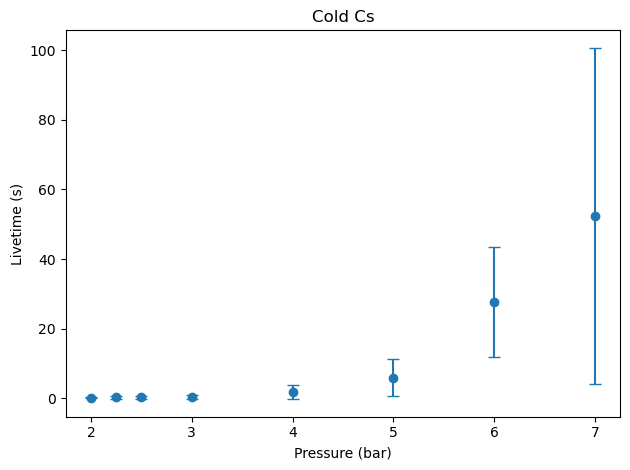

In [81]:
cs_data = ["20260202_16", "20260202_17", "20260202_18", "20260203_0", "20260203_1", "20260203_2", 
           "20260203_3", "20260203_4", "20260203_5", "20260203_6", "20260203_7", "20260203_8"]
livetimes = get_livetime_by_pset(cs_data)
plot_livetime_by_pset(livetimes, title="Cold Cs")

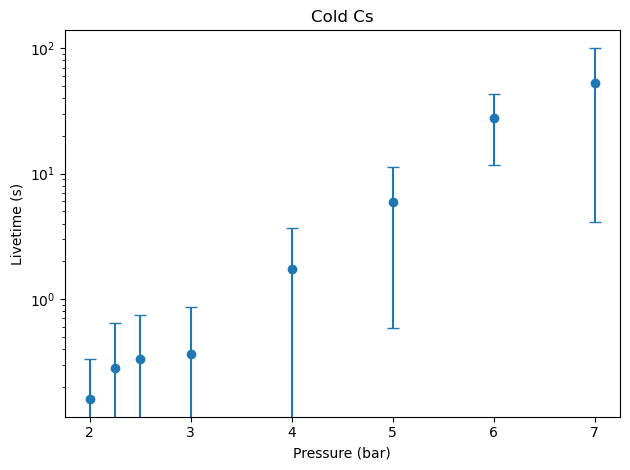

In [83]:
plot_livetime_by_pset(livetimes, title="Cold Cs")

pset: 1.50 bar | n= 246 | total= 1089.23s | mean=4.428s ± 0.201s
pset: 2.00 bar | n= 315 | total= 1738.95s | mean=5.520s ± 0.261s
pset: 2.50 bar | n= 310 | total= 2007.12s | mean=6.475s ± 0.306s
pset: 3.00 bar | n= 331 | total= 2526.33s | mean=7.632s ± 0.394s
pset: 4.00 bar | n= 439 | total= 7268.87s | mean=16.558s ± 0.749s
pset: 5.00 bar | n= 470 | total=16191.63s | mean=34.450s ± 1.561s




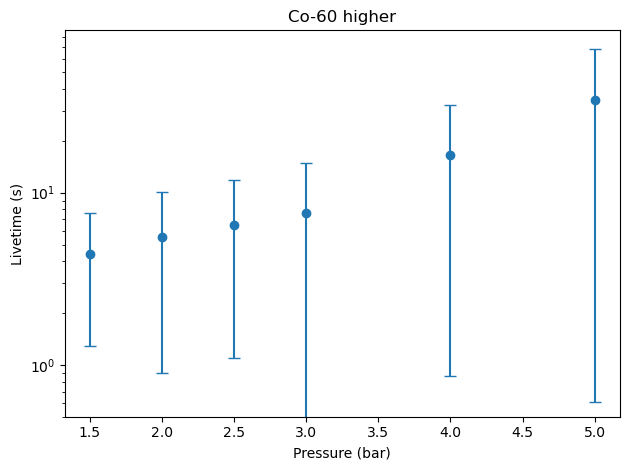

In [23]:
co_data = gen_run_numbers([("20260220", 5, 13), ("20260221", 0, 14), ("20260222", 0, 14), ("20260223", 0, 11), ("20260224", 0, 13)])
co_livetimes = get_livetime_by_pset_rounded(co_data, min_livetime=30)
plot_livetime_by_pset(co_livetimes, title="Co-60 higher")